# Baseline 算法

动物分类教程

使用 Python 进行编程文档请参阅 https://docs.python.org/zh-cn/3/contents.html 。

使用 PyTorch 框架，下载、文档等详情参阅 https://pytorch.org/ ，具体中文文档参阅 https://www.pytorch.wiki/ 。

## 环境配置

在运行本代码前，你需要在以下选项二选一完成：本地环境配置或使用 Google Colab * <a href="https://colab.research.google.com/drive/1Lf0Y5-3gvjKKggQTf1zWrEqHYYIVp3z2#scrollTo=Omm0IoVSJ4Kw" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
完成。若你使用 Colab 可以忽略以下配置环境的过程，可直接阅读下一节。

建议你下载 Anaconda 完成虚拟环境的配置，https://www.anaconda.com ，因为在不同的项目中需要的 Python 版本、不同包的版本可能不同，因此需要不同包的管理软件。Anaconda 的使用，参阅 https://anaconda.cloud/support-center ，或 https://zhuanlan.zhihu.com/p/348120084 获得对新手更为友好的中文教程。

Colab 使用建议：你可以使用你的 Google Drive，将数据集上传至 Google Drive 后，进行挂载使用。否则需要每次会话时重复上传。Google Drive 挂载在 Colab 使用参阅 https://blog.csdn.net/aiynmimi/article/details/88238246

## 数据读入

如何读入数据？参阅 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html ，我们进行对数据集的读入。
在真正读入前，我们先进行一些预处理。

In [1]:
NUM_CLASSES = 22
LABELS = [
    "ape", "bear", "bison", "cat", 
    "chicken", "cow", "deer", "dog",
    "dolphin", "duck", "eagle", "fish", 
    "horse", "lion", "lobster", "pig", 
    "rabbit", "shark", "snake", "spider", 
    "turkey", "wolf"
]
LABEL_MAP = {
    0: "ape", 1: "bear", 2: "bison", 3: "cat", 
    4: "chicken", 5: "cow", 6: "deer", 7: "dog",
    8: "dolphin", 9: "duck", 10: "eagle", 11: "fish", 
    12: "horse", 13: "lion", 14: "lobster", 
    15: "pig", 16: "rabbit", 17: "shark", 18: "snake", 
    19: "spider", 20:  "turkey", 21: "wolf"
}

你还需要把训练集进行分割，分割出 Valid 集

由于本任务数据的特殊性，可以直接使用 ImageFolder ，而不需要单独设计 Dataset 类，因此先定义 transformss, 参阅 https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html 。

In [2]:
from configparser import Interpolation
from torchvision import transforms
import torch
train_transform = transforms.Compose(
    (
        transforms.Resize(256),
        #transforms.RandomRotation(5, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224),
        #transforms.Grayscale(3),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])))

test_transform = transforms.Compose((transforms.ToTensor(), transforms.Resize(256), transforms.CenterCrop(224), transforms.Normalize([0.485, 0.456, 0.406],
                                                                                                                                     [0.229, 0.224, 0.225])))


自定义VisionDataset子类

In [3]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
from pathlib import Path
import re
class AnimalDataset(VisionDataset):
    def __init__(self, root: str, transforms: Optional[Callable] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)
        data_path = Path(self.root)
        image_list = list(data_path.glob('*.png'))
        self.images = [str(i) for i in image_list]
    
    def __getitem__(self, index: int) -> Any:
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')  # 读取到的是RGB， W, H, C
        image = self.transforms(image)   # transform转化image为：C, H, W

        label = re.sub(r'\D', "", image_path)
        return image, int(label)
    
    def __len__(self) -> int:
        return len(self.images)
    

将训练、测试集读入 DataLoader

In [4]:
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_path = './Animals Dataset' #@param 
batch_size = 32 #@param
num_workers = 0 #@param
val_size = 100 #@param 

train_path = (os.path.join(data_path, 'train'))
test_path = (os.path.join(data_path, 'test'))

train_dataset = ImageFolder(
    train_path,
    train_transform)
test_dataset = AnimalDataset(
    test_path,
    test_transform)
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_size, val_size])


随机挑选16张图片测试数据读入是否顺利

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

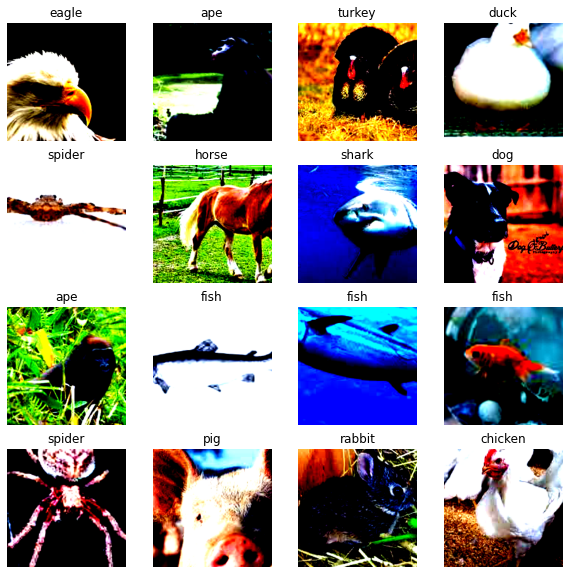

In [5]:
import matplotlib.pyplot as plt
from torch import randint
%matplotlib inline
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

## 建立模型

本节介绍如何定义一个模型，参阅 https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

先进行预处理

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=val_size,
    num_workers=num_workers,
    shuffle=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=num_workers)

Using cuda device


定义模型类，注意到 PyTorch 是动态图，因此在数据进行前向传播时我们相当于已经定义了 Backpropagation 反向传播。

这样模型就可以定义为：

In [7]:
from torchvision import models
model = models.resnet34().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

设置模型训练超参数、损失函数与优化器

In [8]:
learning_rate = 1e-2  # @param
# batch_size = 32 #@param 此处貌似在DataLoader部分定义ganggai了
epochs = 100  # @param
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)


定义评价指标

In [9]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
      self.name = name
      self.fmt = fmt
      self.reset()

  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

  def __str__(self):
      fmtstr = '{name} {avg' + self.fmt + '}'
      return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Training loss', ':.4e')
top1 = AverageMeter('Acc@1', ':6.2f')
top5 = AverageMeter('Acc@5', ':6.2f')

训练

In [10]:
import time

val_loss_history = []
loss_history = []
top1_history = []
top5_history = []
best_loss = 0x7fffffff

start = time.time()
for i in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    data_time.update(time.time() - start)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  batch_time.update(time.time() - start)
  start = time.time()

  with torch.no_grad():
    for batch, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      val_loss = loss_fn(pred, y)
      if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_epoch = i
        best_model = model
      acc1, acc5 = accuracy(pred, y, topk=(1, 5))
      loss_history.append(loss.item())
      val_loss_history.append(val_loss.item())
      top1_history.append(acc1[0])
      top5_history.append(acc5[0])
      losses.update(loss.item(), X.size(0))
      top1.update(acc1[0], X.size(0))
      top5.update(acc5[0], X.size(0))
    scheduler.step(val_loss)
      
  print(f"Epoch:{i + 1}: {batch_time}, {losses}, Validation loss {val_loss.item():.4e}, {top1}, {top5}, learning rate {optimizer.state_dict()['param_groups'][0]['lr']}")
  losses.reset()
  top1.reset()
  top5.reset()

print(f"Best Epoch:{best_epoch + 1}, loss: {best_loss}, Acc@1: {top1_history[best_epoch]}, Acc@5: {top5_history[best_epoch]}")


Epoch:1: Time 16.407, Training loss 3.4406e+00, 2.9057e+00, Acc@1  18.00, Acc@5  43.00, learning rate 0.01
Epoch:2: Time 16.028, Training loss 3.0956e+00, 3.3873e+00, Acc@1  14.00, Acc@5  43.00, learning rate 0.01
Epoch:3: Time 15.942, Training loss 2.3308e+00, 2.6640e+00, Acc@1  24.00, Acc@5  61.00, learning rate 0.01
Epoch:4: Time 15.891, Training loss 2.7400e+00, 2.6855e+00, Acc@1  26.00, Acc@5  57.00, learning rate 0.01
Epoch:5: Time 16.251, Training loss 2.2610e+00, 2.5448e+00, Acc@1  31.00, Acc@5  62.00, learning rate 0.01
Epoch:6: Time 16.533, Training loss 2.0845e+00, 2.3764e+00, Acc@1  29.00, Acc@5  67.00, learning rate 0.01
Epoch:7: Time 16.738, Training loss 1.8072e+00, 2.4724e+00, Acc@1  26.00, Acc@5  61.00, learning rate 0.01
Epoch:8: Time 16.855, Training loss 2.5631e+00, 2.3459e+00, Acc@1  32.00, Acc@5  69.00, learning rate 0.01
Epoch:9: Time 16.969, Training loss 2.0769e+00, 2.2042e+00, Acc@1  37.00, Acc@5  78.00, learning rate 0.01
Epoch:10: Time 17.088, Training loss 

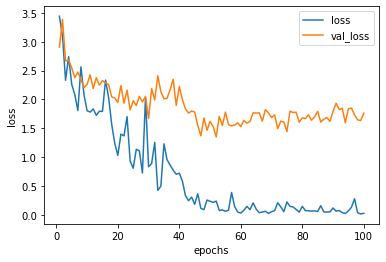

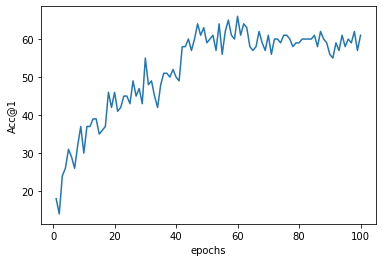

<Figure size 432x288 with 0 Axes>

In [11]:
import numpy as np
plt.plot(np.arange(1, epochs+1), loss_history, label="loss")
plt.plot(np.arange(1, epochs+1), val_loss_history, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
#plt.savefig("loss.png")
plt.show()
plt.clf()
plt.plot(np.arange(1, epochs+1), [i.item() for i in top1_history])
plt.xlabel("epochs")
plt.ylabel("Acc@1")
#plt.savefig("Acc.png")
plt.show()
plt.clf()

由于模型过于简单，因此训练准确率不高。你可以尝试训练其它的模型（甚至于预训练模型，但预训练模型如何进行训练也是一个值得讨论的问题）。
同时，这里并没有使用 Valid 集来进行评价，而是使用了 train 集，你可以尝试加入 Valid 集（如提前分割，或用其他方式等）



# 输出结果

输出结果非常简单，与训练类似，但模型不能更新参数

In [12]:
#model = torch.load('./ResNet34_8.30_1700.pt')

In [13]:
import numpy as np
def test(model, test_image, name_prefix):
  model.eval()
  labels = []
  image_numbers = []
  with torch.no_grad():
    for _, (images, label) in enumerate(test_image):
      images = images.to(device)
      y = model(images)
      batch_labels = torch.argmax(y, dim=1)
      labels.append(batch_labels)
      image_numbers.append(label)
  ans = torch.cat(labels, 0).cpu().numpy()
  image_numbers = torch.cat(image_numbers, 0).cpu().numpy()
  res = {image_numbers[i]:LABEL_MAP[j] for i, j in enumerate(ans)}
  print(f"{name_prefix} model result:", res)
  return res

res = test(best_model, test_loader, "best")



best model result: {18: 'wolf', 37: 'ape', 56: 'spider', 75: 'lion', 0: 'horse', 1: 'duck', 10: 'ape', 100: 'chicken', 101: 'cow', 102: 'dog', 103: 'cat', 104: 'bear', 105: 'lobster', 106: 'pig', 107: 'horse', 108: 'bison', 109: 'wolf', 11: 'snake', 12: 'ape', 13: 'fish', 14: 'turkey', 15: 'dog', 16: 'chicken', 17: 'lion', 19: 'turkey', 2: 'ape', 20: 'duck', 21: 'turkey', 22: 'shark', 23: 'duck', 24: 'bear', 25: 'duck', 26: 'dog', 27: 'pig', 28: 'lion', 29: 'chicken', 3: 'deer', 30: 'lobster', 31: 'fish', 32: 'chicken', 33: 'lion', 34: 'fish', 35: 'deer', 36: 'lobster', 38: 'snake', 39: 'cat', 4: 'cow', 40: 'pig', 41: 'fish', 42: 'snake', 43: 'snake', 44: 'bear', 45: 'eagle', 46: 'rabbit', 47: 'lobster', 48: 'dog', 49: 'lobster', 5: 'fish', 50: 'dolphin', 51: 'lobster', 52: 'horse', 53: 'bison', 54: 'shark', 55: 'turkey', 57: 'shark', 58: 'bison', 59: 'bison', 6: 'chicken', 60: 'spider', 61: 'bear', 62: 'spider', 63: 'duck', 64: 'cat', 65: 'cow', 66: 'lobster', 67: 'ape', 68: 'dolphin'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

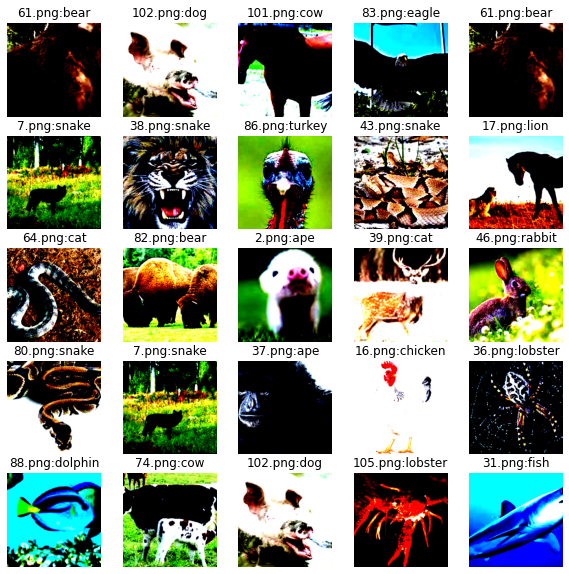

In [17]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(test_dataset), size=(1,)).item()
    img, num = test_dataset[sample_idx]
    label = res[num]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{num}.png:{label}")
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

# 保存模型

参阅 https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [15]:
#网络_日期_时间.pt
import time
t = time.localtime(time.time())
torch.save(best_model, f'./ResNet34_{t[1]}.{t[2]}_{t[3]}{t[4]}.pt')

In [16]:
#model = torch.load('model.path')